#Homework 3: Gradien Descent and Model (parameters/features) Selection (20pt)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from IPython.display import clear_output
%matplotlib inline

### Download the dataset from class, missing values imputed for you

In [ ]:
Data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
                    header=None, na_values=["?"])
Data.dropna(subset=Data.columns[Data.columns != 1], inplace=True)
imputer = SimpleImputer()
Data[1] = imputer.fit_transform(Data[[1]])

In [ ]:
len(Data)

193

In [ ]:
#pd.set_option('display.max_columns', None)
Data.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,121.132075,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.000000,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.000000,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


We itroduced Stochastic Gradien Descent algorithm:

1) Initialize randomly weights $w=(w_0, w_1, \ldots, w_d)^T$

2) Take a point $\tilde{x}^{(i)}=(x_0^{(i)}, x_1^{(i)}, \ldots, x_d^{(i)})^T$ with $x_0^{(i)}=1$

3) Calculate error (MSE) on it:
$$Loss(a(x^{(i)}), y^{(i)}) = (w^T\tilde{x}^{(i)} - y^{(i)})^2 \qquad \text{ or }\quad (y^{(i)} - w^T\tilde{x}^{(i)})^2$$

4) Calculate gradient of the loss function:
$$\nabla Loss(a(x^{(i)}), y^{(i)}) = 2\tilde{x}^{(i)}(w^T\tilde{x}^{(i)} - y^{(i)})\qquad (*)$$

5) Update weights:
$$
w^{new} = w^{old} - \eta\nabla Loss(a(x^{(i)}), y^{(i)}),
$$
where $\eta\in (0,1)$ is the learning rate.

*Derivation of the expression $(*)$.* The loss function looks as follows:
$$Loss(a(x^{(i)}), y^{(i)})=(w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)})^2$$
Gradient is a vector of derivatives with respect to every $w_j:$
$$\nabla (w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)})^2
= \begin{pmatrix}2x_0^{(i)}(w_0x_0^{(i)}+w_1x_1^{(i)} + \ldots +w_dx_d^{(i)} - y^{(i)}) \\ 2x_1^{(i)}(w_0x_0^{(i)}+w_1x_1^{(i)} + \ldots +w_dx_d^{(i)} - y^{(i)})\\ \vdots \\ 2x_d^{(i)}(w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)})\end{pmatrix}$$
$$= \begin{pmatrix}2x_0^{(i)} \\ 2x_1^{(i)}\\ \vdots \\ 2x_d^{(i)}\end{pmatrix} (w_0x_0^{(i)}+w_1x_1^{(i)}+\ldots+w_dx_d^{(i)} - y^{(i)}) =2\tilde{x}^{(i)}(w^T\tilde{x}^{(i)} - y^{(i)})$$

#1. (7pt) A class with realization of SGD algorithm is provided below.
You are asked to add code, such that for *batch_size=$B\geq 1$* it performes mini-batch SGD. For *batch_size=len(Data)* it peformes standard Gradient Descent (GD) using full batch.  

If parameter `warm_start=True,` use the weights calculated on the previouse step.

Do not use $sum()$ or for loop at all except iterating through the data in **epoch**. For example, to compute the loss over all the data, we use matrix nodation
$$
\frac{1}{N}\sum_{i=1}^{N}(w^T\tilde{x}^{(i)}-y^{(i)})^2=\frac{1}{N}(Xw-y)^T(Xw-y)
$$
that can be coded as
``(X.dot(w)-y).dot(X.dot(w)-y)/len(y)``.

You can get some ideas from Week 3 lectures.

In [ ]:
class MyLinearRegression:
    """
    Parameters
    ----------
    regularization : {None, 'l2'}, default=None  //we will introduce later 'l1' and both

    weight_calc : {'matrix', 'gd', 'sgd'}, default='matrix'
         'matrix',  'gd' (gradient descent), or 'sgd' (stochastic gradient descent)

    Attributes
    ----------
    coefs_ : vector (p, 1) of coefficients, where p is the number of fatures
    intercept_ : bias term
    """

    def __init__(self, regularization=None, weight_calc='matrix', alpha=None, lr=1e-3, batch_size=20):
        if regularization not in [None, 'l2']:
            raise TypeError(f"regularization can not be '{regularization}'")
        if weight_calc not in ['matrix', 'gd', 'sgd']:
            raise TypeError(f"weight_calc can not be '{weight_calc}'")
        if regularization == 'l2' and alpha is None:
            raise TypeError(f"define the l2 regularization coefficient")

        self.weight_calc = weight_calc
        self.batch_size = batch_size
        self.regularization = regularization
        self.alpha = alpha
        self.lr = lr

        self.coefs_ = None
        self.intercept_ = None
        self.X = None
        self.y = None

    def fit(self, X: pd.DataFrame or np.array, y: pd.Series or np.array, lr=None, max_iter = 1000, warm_start=False):
        #We allow to indicate learning rate in both places: initialization and fit
        if lr==None:
            lr = self.lr


        #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        # When batch_size is len(Data), we do GD instead of SGD
        if self.batch_size == len(Data):
          self.weight_calc = 'gd'



        #Cast data into NumPy and create extended matrix X
        if isinstance(X, pd.DataFrame):
            self.X = np.concatenate([np.ones((len(X),1)), X.to_numpy()],axis=1)
        else:
            self.X = np.concatenate([np.ones((len(X),1)), X],axis=1)
        if isinstance(y, pd.Series):
           self.y = y.to_numpy() #pass # Your code here
        else:
            self.y = y

        if self.weight_calc == 'matrix':
            #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
            if self.regularization == None:
              w = np.linalg.inv(self.X.T.dot(self.X)).dot(self.X.T).dot(self.y)   # .dot works the same as matrix multiplication.
            self.intercept_ = w[0]
            self.coefs_ = w[1:].reshape(-1,1)


        elif self.weight_calc == 'gd':
            if warm_start:
                if self.coefs_ == None:
                    w = np.zeros(self.X.shape[1])
                else:
                    w = np.vstack([self.intercept_, self.coefs_]).squeeze()
            else:
                w = np.zeros(self.X.shape[1])

            for epoch in range(max_iter):
                #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
                if self.regularization == None:
                  w = w - lr*2*self.X.T.dot(self.X.dot(w) - self.y)/len(self.y)


                if (epoch + 1) % 100 == 0:
                  loss = np.mean((np.dot(self.X, w).squeeze() - self.y)**2)
                  self.plot(epoch, w, lr, loss)

            #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
            self.intercept_ = w[0]
            self.coefs_ = w[1:].reshape(-1,1)


        elif self.weight_calc == 'sgd':
            if warm_start:
                if self.coefs_ == None:
                    w = np.zeros(self.X.shape[1])
                else:
                    w = np.vstack([self.intercept_, self.coefs_]).squeeze()
            else:
                w = np.zeros(self.X.shape[1])

            for epoch in range(max_iter):
                #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
                # Shuffle the data
                indices = np.random.permutation(len(self.y))
                X_shuffled = self.X[indices]
                y_shuffled = self.y[indices]

                for i in range(0, len(self.y), self.batch_size):
                  # Select a batch
                  X_batch = X_shuffled[i:i + self.batch_size]
                  y_batch = y_shuffled[i:i + self.batch_size]

                  # Compute gradient
                  gradient = (2 / len(y_batch)) * X_batch.T.dot(X_batch.dot(w) - y_batch)

                  # Update weights
                  w = w - lr * gradient

                if (epoch + 1) % 100 == 0:
                  loss = np.mean((np.dot(self.X, w).squeeze() - self.y)**2)
                  self.plot(epoch, w, lr, loss)

            #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
            self.intercept_ = w[0]
            self.coefs_ = w[1:].reshape(-1,1)


    def predict(self, X: pd.DataFrame or np.array):
        '''
        This function takes as input not extended matrix of features X
        returns np.array of size (len(X),)
        '''
        #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        if isinstance(X, pd.DataFrame):
          X = np.concatenate([np.ones((len(X),1)), X.to_numpy()],axis=1)
        else:
          X = np.concatenate([np.ones((len(X),1)), X],axis=1)

        #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        # remember, that after simplifying things we found that y/hat = X*w
        w = np.vstack([self.intercept_, self.coefs_]).squeeze()
        return X.dot(w)


    def score(self, X: pd.DataFrame or np.array, y: pd.Series or np.array):
        '''
        This function takes as input not extended matrix of features X and target y
        returns the coefficient of determination R^2
        '''
        #Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        y_pred = self.predict(X)  # Get predictions

        # Convert y to NumPy array if needed
        if isinstance(y, pd.Series):
            y = y.to_numpy()

        # Compute R² score
        ss_total = np.sum((y - np.mean(y))**2)  # Total Sum of Squares
        ss_residual = np.sum((y - y_pred)**2)  # Residual Sum of Squares

        return 1 - (ss_residual / ss_total)  # R² formula



    # def batch_loss(self, X, y):
    #     return np.mean((self.predict(X) - y)**2)

    def plot(self, epoch, w, lr, loss):
        clear_output(True)
        plt.figure(figsize=(10,8))
        plt.scatter(self.X[:,1], self.y, label="data")
        plt.scatter(self.X[:,1], self.X.dot(w), color="orange", linewidth=5, label="predictions")
        plt.xlabel("Feature 1", fontsize=14)
        plt.ylabel("Target", fontsize=14)
        plt.title(f"SGD batch size = {self.batch_size}, epoch = {epoch}, lr={lr}, RMSE={np.sqrt(loss)}", fontsize=18)
        plt.legend(fontsize=14)
        plt.show()

#2. (3pt) Run this class with the following parameters:

max_epochs = 100 and 1000

batch_size = 1, 10, 50, full

lr = 1e-3, 1e-6, 1e-8

Report the results (RMSE) and try to explain how batch size coordinates with the learning rate. How does scaling of the features influence the training?

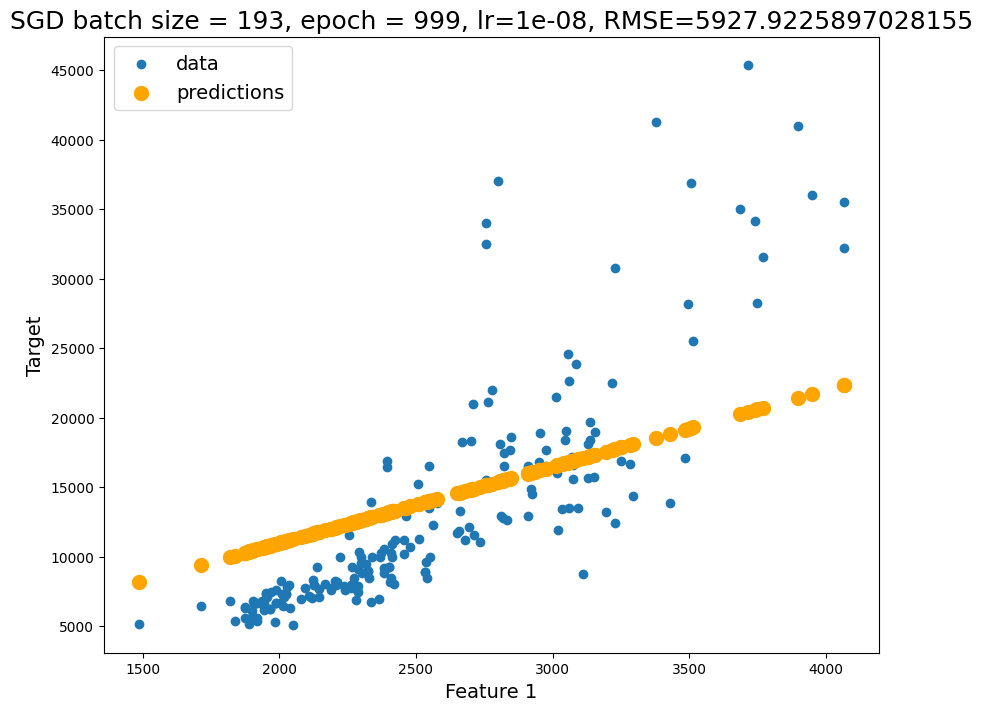

In [ ]:
results = []
for b in [1, 10, 50, len(Data)]:
  for m in [100, 1000]:
    for lr in [1e-3, 1e-6, 1e-8]:
      sgd = MyLinearRegression(lr=lr, batch_size=b, weight_calc='sgd')
      sgd.fit(Data[[13]],Data[25], max_iter=m)
      r = np.sqrt(np.mean((sgd.predict(Data[[13]])-Data[25].to_numpy())**2))
      results.append({'Batch Size': b, 'Max Epochs': m, 'Learning Rate': lr, 'RMSE Value': r})

In [ ]:
results_df = pd.DataFrame(results)
results_df

,Batch Size,Max Epochs,Learning Rate,RMSE Value
0,1,100,1.000000e-03,NaN
1,1,100,1.000000e-06,NaN
2,1,100,1.000000e-08,6.027619e+03
3,1,1000,1.000000e-03,NaN
4,1,1000,1.000000e-06,NaN
5,1,1000,1.000000e-08,6.613869e+03
6,10,100,1.000000e-03,NaN
7,10,100,1.000000e-06,NaN
8,10,100,1.000000e-08,5.965143e+03
9,10,1000,1.000000e-03,NaN


## Normalize the feature column and repeat the experiment.

In [ ]:
# Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆* V:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_normalized = scaler.fit_transform(Data[[13]])  # Standardize feature column
# Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆* ^:

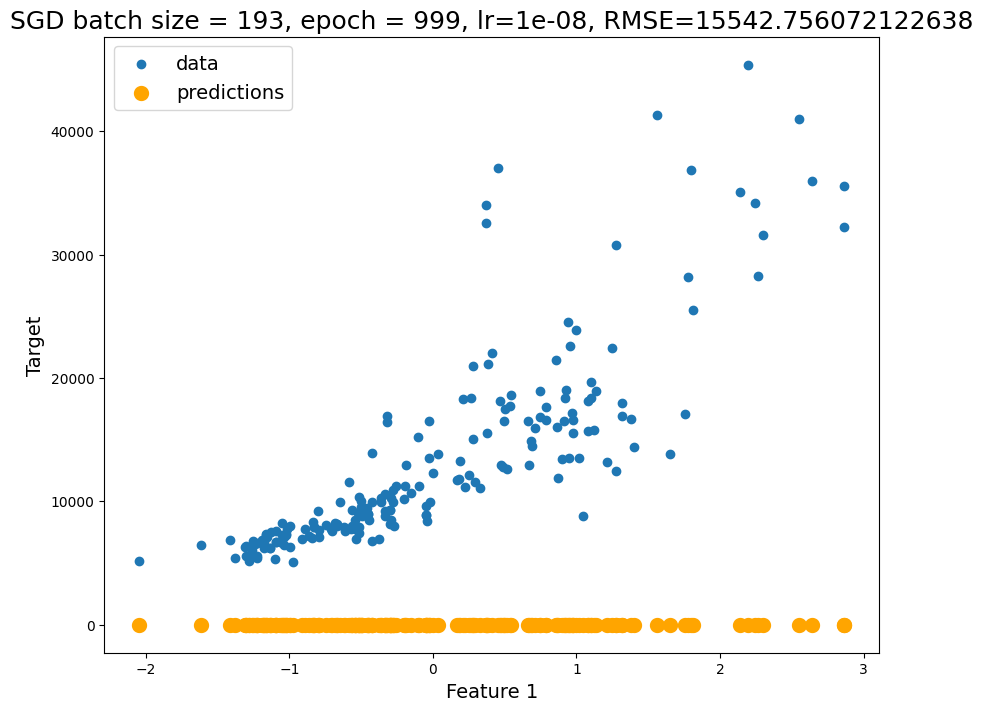

In [ ]:
# Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆* V:
results_standardized = []

for b in [1, 10, 50, len(Data)]:
    for m in [100, 1000]:
        for lr in [1e-3, 1e-6, 1e-8]:
            sgd_standardized = MyLinearRegression(lr=lr, batch_size=b, weight_calc='sgd')
            sgd_standardized.fit(X_normalized, Data[25], max_iter=m)

            # Predict using the normalized feature column
            predictions_standardized = sgd_standardized.predict(X_normalized)
            r = np.sqrt(np.mean((predictions_standardized - Data[25].to_numpy())**2))

            results_standardized.append({'Batch Size': b, 'Max Epochs': m, 'Learning Rate': lr, 'RMSE Value': r})
# Your code is here ╰( ͡° ͜ʖ ͡° )つ──☆* ^:

In [ ]:
results_df_standardized = pd.DataFrame(results_standardized)
results_df_standardized

,Batch Size,Max Epochs,Learning Rate,RMSE Value
0,1,100,1.000000e-03,4435.029944
1,1,100,1.000000e-06,15003.288914
2,1,100,1.000000e-08,15537.531620
3,1,1000,1.000000e-03,4435.001682
4,1,1000,1.000000e-06,11055.042346
5,1,1000,1.000000e-08,15488.044995
6,10,100,1.000000e-03,4442.982586
7,10,100,1.000000e-06,15486.021823
8,10,100,1.000000e-08,15542.470101
9,10,1000,1.000000e-03,4435.055523


Report the results (RMSE) and try to explain how batch size coordinates with the learning rate. How does scaling of the features influence the training?

###Type the answer

Batch size and learning rate work together to influence the stability and efficiency of gradient descent. Small batch size needs a smaller learning rate to prevent instability. Large batch size allows for a larger learning rate since the gradient estimate is more accurate.

When we look at the impact of scaling, before scaling the features we had high RMSE, and even some NaN results for large learning rates. After scaling, RMSE values decreased and become more stable. So, scaling was made a significant positive impact. A properly scaled dataset allows weight updates to be more uniform, leading to more efficient learning.

#3. (10pt) In this part you will use the built-in functions for Linear Regression. They are using SGD under the hood.

(1pt) Plot the histograms for numerical data and bar-plots for categorical features, add $x$ axis name (file Description.txt). You can get the names of the columns as follows:
```
# List of numerical columns (assuming they have numeric data types)
numerical_columns = Data.select_dtypes(exclude=['object']).columns.tolist()

# List of nominal (categorical) columns (assuming they have object data types)
nominal_columns = Data.select_dtypes(include=['object']).columns.tolist()

```
And then methods
```
Data[column].hist()
Data[column].value_counts().plot(kind='bar')
```

(1pt) Transform categorical data into numerical ([see SGD notebook from Fall](https://github.com/anton-selitskiy/RIT_ML/blob/main/2024_fall/Lectures/ML9.ipynb)).

(3pt) Choose the features for prediction ([see Model Selection notebook from Week 4](https://github.com/anton-selitskiy/RIT_ML/tree/main/2025_spring/Week04_SGD/ML7.ipynb))

(3pt) Choose the model by the grid-search (using validation set or cross-validation)

(2pt) Train the best model and report it's performance on the Test set. Justify your choice of the metric for evaluation.

In [ ]:
# To have the names of the columns, we upload file Description.txt
descripsion = pd.read_csv('https://raw.githubusercontent.com/anton-selitskiy/RIT_ML/main/2024_spring/Homeworks/Description.txt', delimiter=':', header=None)
Data.columns = descripsion[0].str.strip() #delete extra spaces in the column names
Data.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,121.132075,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,121.132075,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.000000,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.000000,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


# (1pt) Plot the histograms for numerical data and bar-plots for categorical features, add  x  axis name.

In [ ]:
import seaborn as sns

In [ ]:
# List of numerical columns (assuming they have numeric data types)
numerical_columns = Data.select_dtypes(exclude=['object']).columns.tolist()

# List of nominal (categorical) columns (assuming they have object data types)
nominal_columns = Data.select_dtypes(include=['object']).columns.tolist()


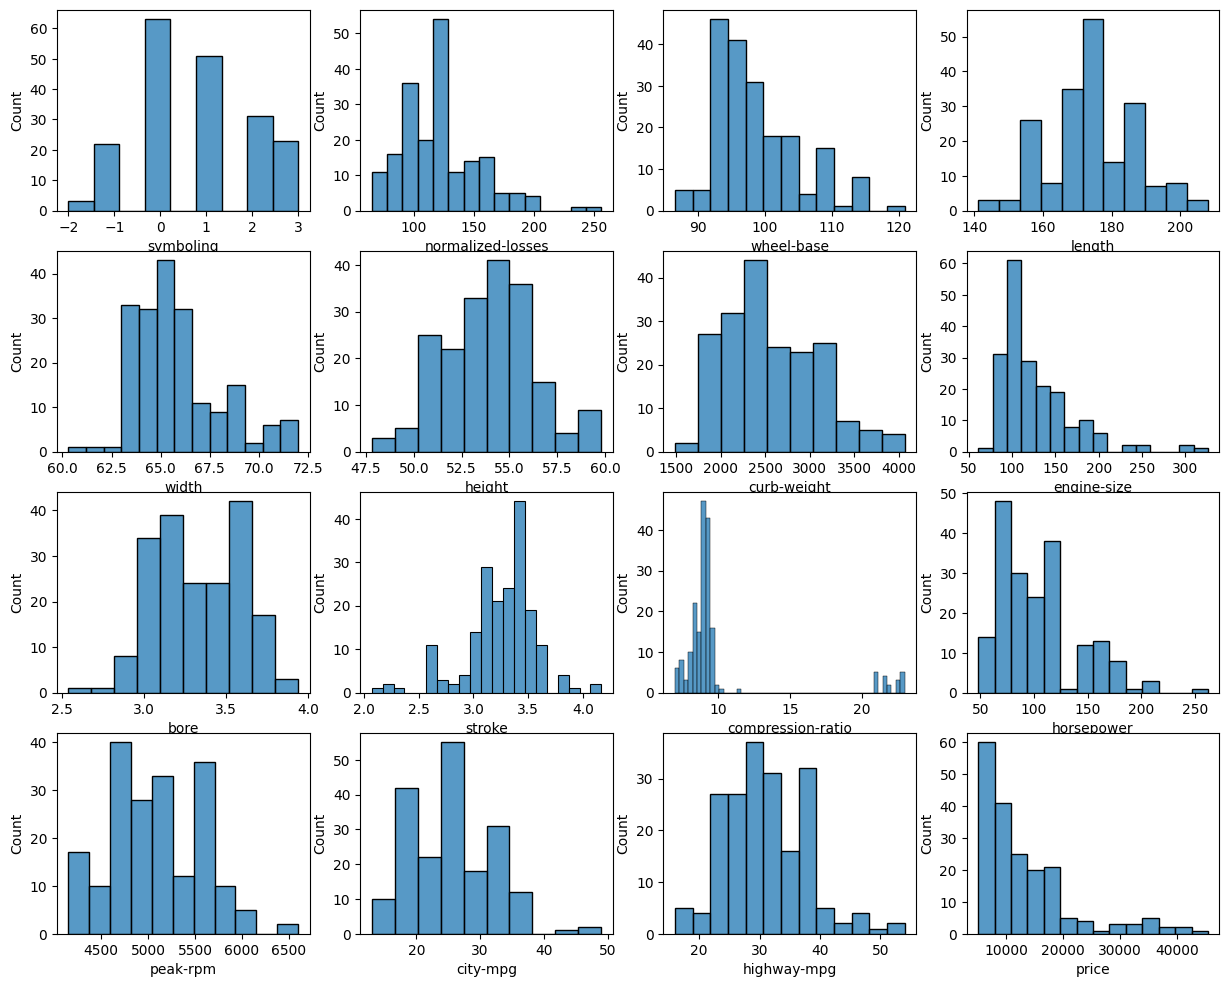

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=len(numerical_columns)//4, figsize=(15, 12))

for i, column in enumerate(numerical_columns):
    sns.histplot(Data[column], ax=axes[i//4, i%4], kde=False)

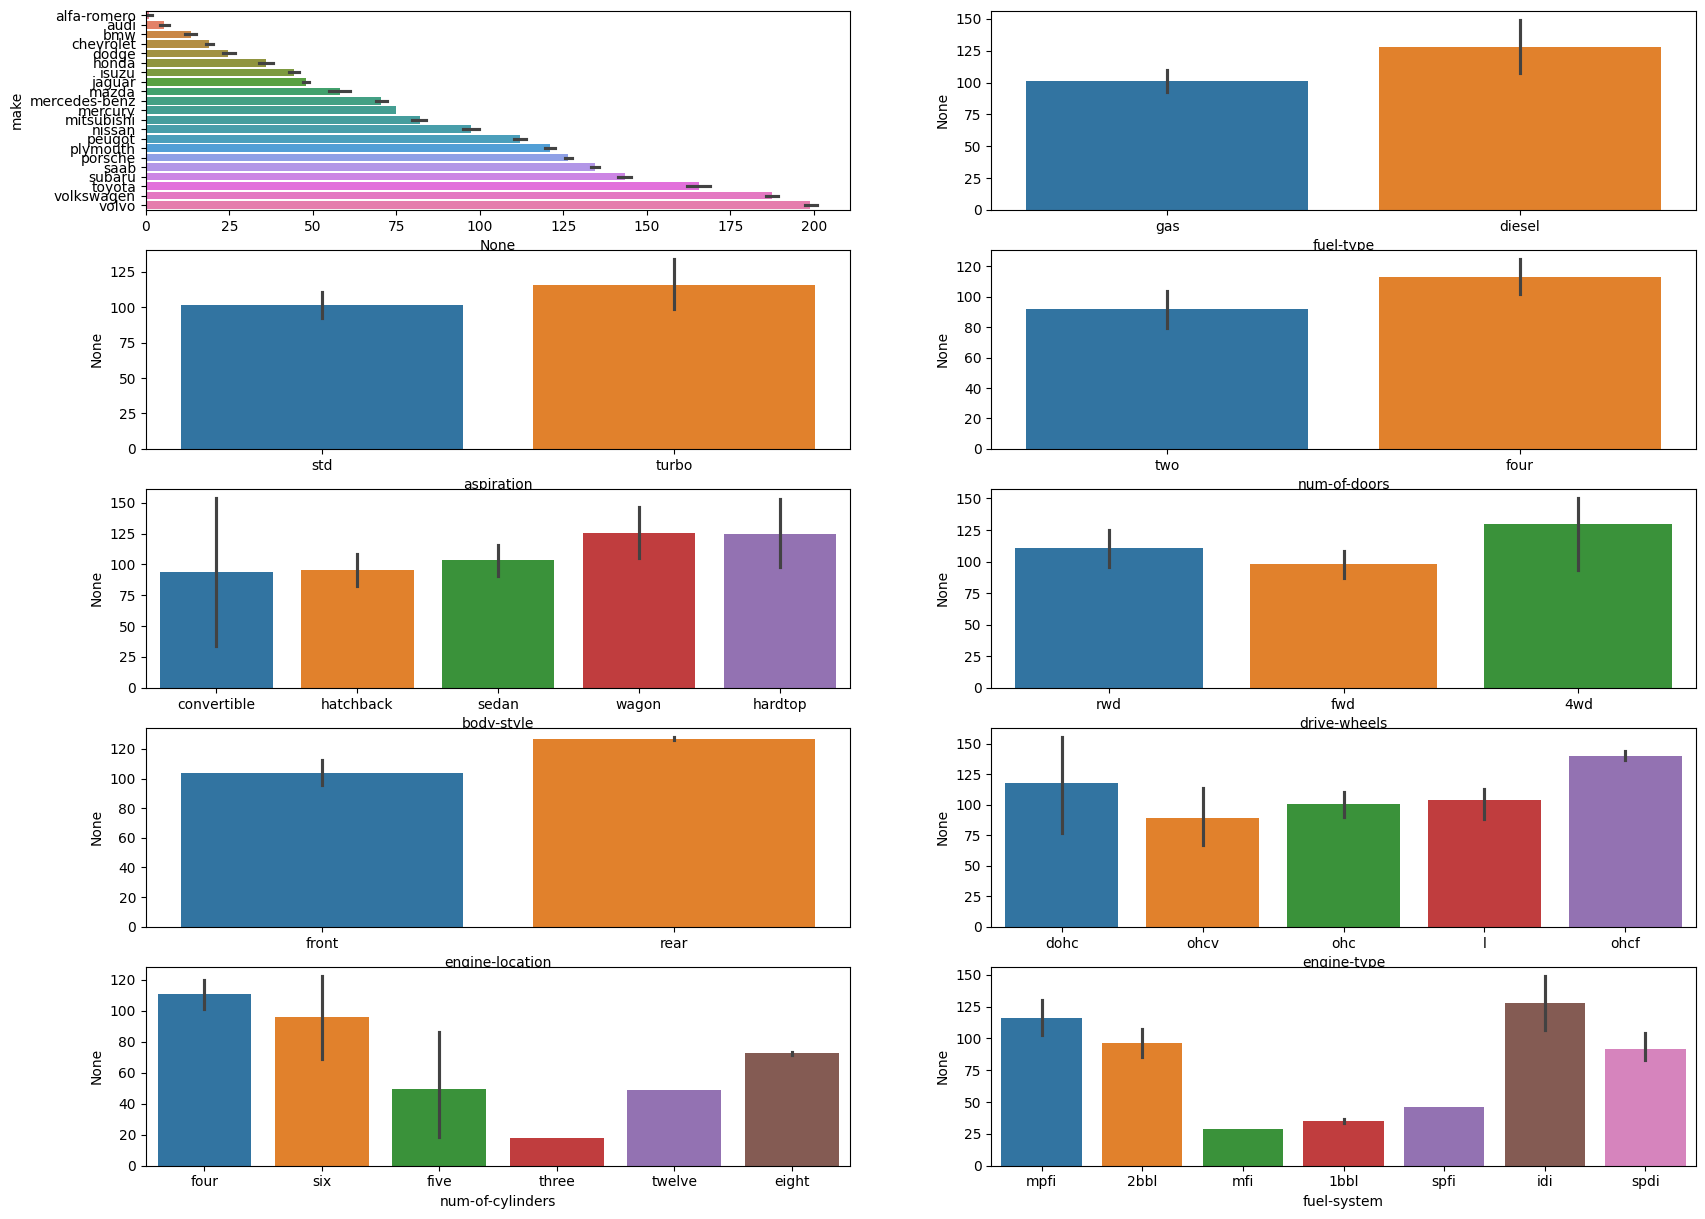

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=len(nominal_columns)//5, figsize=(20, 15))

for i, column in enumerate(nominal_columns):
    if i == 0:
      sns.barplot(Data, x=Data.index, y=column, ax=axes[i//2, i%2], hue=column)
    else:
      sns.barplot(Data, y=Data.index, x=column, ax=axes[i//2, i%2], hue=column)

# (1pt) Transform categorical data into numerical.

In [ ]:
# Create features and target
y = Data.iloc[:,-1]
X = Data.iloc[:,:-1]

In [ ]:
# Because I'm using cross-validation, don't need Validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
               X, y, test_size=0.33, random_state=42)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [ ]:
# Apply One-Hot-Encoder to transform the categorical data to numerical
transform = ColumnTransformer([('OneHot', OneHotEncoder(drop='first', handle_unknown='ignore'),
                                X_train.columns[(X_train.dtypes == "object")].values)], remainder='passthrough')

In [ ]:
X_train_hot = pd.DataFrame(transform.fit_transform(X_train), columns=transform.get_feature_names_out())
X_test_hot = pd.DataFrame(transform.transform(X_test), columns=transform.get_feature_names_out())

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
X_train_hot = pd.DataFrame(transform.transform(X_train), columns=transform.get_feature_names_out())
X_train_hot.head()

,OneHot__make_audi,OneHot__make_bmw,OneHot__make_chevrolet,OneHot__make_dodge,OneHot__make_honda,OneHot__make_jaguar,OneHot__make_mazda,OneHot__make_mercedes-benz,OneHot__make_mitsubishi,OneHot__make_nissan,...,remainder__height,remainder__curb-weight,remainder__engine-size,remainder__bore,remainder__stroke,remainder__compression-ratio,remainder__horsepower,remainder__peak-rpm,remainder__city-mpg,remainder__highway-mpg
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,59.8,2535.0,122.0,3.34,3.46,8.5,88.0,5000.0,24.0,30.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56.1,2758.0,121.0,3.54,3.07,9.3,110.0,5250.0,21.0,28.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,54.5,1951.0,97.0,3.15,3.29,9.4,69.0,5200.0,31.0,37.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,49.7,3071.0,181.0,3.43,3.27,9.0,160.0,5200.0,19.0,25.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,52.4,2823.0,152.0,2.68,3.47,9.0,154.0,5000.0,19.0,26.0


In [ ]:
X_test_hot = pd.DataFrame(transform.transform(X_test), columns=transform.get_feature_names_out())

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 8, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# (3pt) Choose the features for prediction.

In [ ]:
# This was not very helpful

# cor = pd.concat([X_train_hot, y_train], axis=1).corr()
# fig, ax = plt.subplots(figsize=(12,12))
# sns.heatmap(cor, cmap="RdBu", annot=True)

In [ ]:
from sklearn.linear_model import SGDRegressor, Lasso, Ridge, ARDRegression, ElasticNet, HuberRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression, r_regression, f_regression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score

Huber Regression:

In [ ]:
MI_select_Huber = []
for r in range(1, X_train_hot.shape[1]):
  pipe2 = Pipeline([('sc', StandardScaler()), ('reg', HuberRegressor(max_iter=1000))]) #HuberRegressor(max_iter=1000) # ElasticNet(l1_ratio=0.9)
  MI_select_Huber.append(cross_val_score(pipe2, SelectKBest(mutual_info_regression, k=r).fit_transform(X_train_hot, y_train), y_train, cv=10).mean())

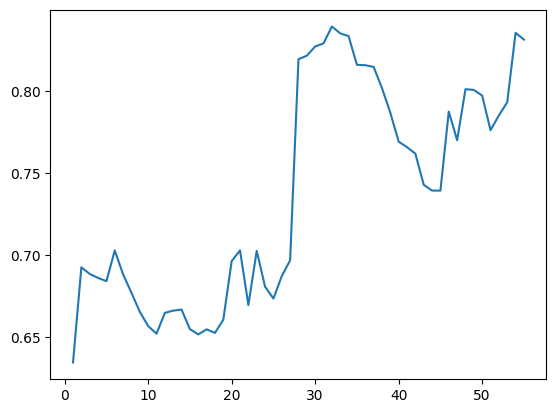

In [ ]:
plt.plot(list(range(1, X_train_hot.shape[1])), MI_select_Huber)

In [ ]:
best_k_Huber = np.argmax(MI_select_Huber[:35])+1
best_k_Huber

32

In [ ]:
MI_select_Huber = SelectKBest(mutual_info_regression, k=best_k_Huber)
MI_select_Huber.fit_transform(X_train_hot, y_train)
best_features_Huber = MI_select_Huber.get_feature_names_out()
best_features_Huber

array(['OneHot__make_audi', 'OneHot__make_mercedes-benz',
       'OneHot__make_mitsubishi', 'OneHot__make_peugot',
       'OneHot__make_subaru', 'OneHot__make_volvo',
       'OneHot__aspiration_turbo', 'OneHot__body-style_hatchback',
       'OneHot__drive-wheels_fwd', 'OneHot__drive-wheels_rwd',
       'OneHot__engine-type_l', 'OneHot__engine-type_ohc',
       'OneHot__engine-type_ohcv', 'OneHot__num-of-cylinders_five',
       'OneHot__num-of-cylinders_four', 'OneHot__num-of-cylinders_six',
       'OneHot__fuel-system_2bbl', 'OneHot__fuel-system_mpfi',
       'remainder__symboling', 'remainder__normalized-losses',
       'remainder__wheel-base', 'remainder__length', 'remainder__width',
       'remainder__height', 'remainder__curb-weight',
       'remainder__engine-size', 'remainder__bore', 'remainder__stroke',
       'remainder__horsepower', 'remainder__peak-rpm',
       'remainder__city-mpg', 'remainder__highway-mpg'], dtype=object)

Ridge Regression:

In [ ]:
MI_select_Ridge = []
for r in range(1, X_train_hot.shape[1]):
  pipe2 = Pipeline([('sc', StandardScaler()), ('reg', Ridge())])
  MI_select_Ridge.append(cross_val_score(pipe2, SelectKBest(mutual_info_regression, k=r).fit_transform(X_train_hot, y_train), y_train, cv=10).mean())

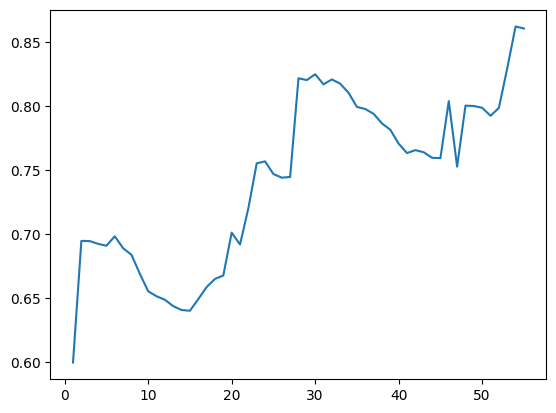

In [ ]:
plt.plot(list(range(1, X_train_hot.shape[1])), MI_select_Ridge)

In [ ]:
best_k_Ridge = np.argmax(MI_select_Ridge[:35])+1
best_k_Ridge

30

In [ ]:
MI_select_Ridge = SelectKBest(mutual_info_regression, k=best_k_Ridge)
MI_select_Ridge.fit_transform(X_train_hot, y_train)
best_features_Ridge = MI_select_Ridge.get_feature_names_out()
best_features_Ridge

array(['OneHot__make_audi', 'OneHot__make_mercedes-benz',
       'OneHot__make_peugot', 'OneHot__make_volvo',
       'OneHot__aspiration_turbo', 'OneHot__body-style_hatchback',
       'OneHot__drive-wheels_fwd', 'OneHot__drive-wheels_rwd',
       'OneHot__engine-type_l', 'OneHot__engine-type_ohc',
       'OneHot__engine-type_ohcv', 'OneHot__num-of-cylinders_five',
       'OneHot__num-of-cylinders_four', 'OneHot__num-of-cylinders_six',
       'OneHot__fuel-system_2bbl', 'OneHot__fuel-system_mpfi',
       'remainder__symboling', 'remainder__normalized-losses',
       'remainder__wheel-base', 'remainder__length', 'remainder__width',
       'remainder__height', 'remainder__curb-weight',
       'remainder__engine-size', 'remainder__bore', 'remainder__stroke',
       'remainder__horsepower', 'remainder__peak-rpm',
       'remainder__city-mpg', 'remainder__highway-mpg'], dtype=object)

Elastic Net Regression:

In [ ]:
MI_select_Elastic = []
for r in range(1, X_train_hot.shape[1]):
  pipe2 = Pipeline([('sc', StandardScaler()), ('reg', ElasticNet(l1_ratio=0.9))]) #HuberRegressor(max_iter=1000) # ElasticNet(l1_ratio=0.9)
  MI_select_Elastic.append(cross_val_score(pipe2, SelectKBest(mutual_info_regression, k=r).fit_transform(X_train_hot, y_train), y_train, cv=10).mean())

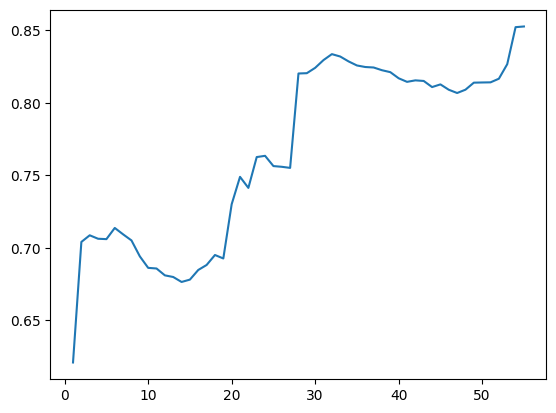

In [ ]:
plt.plot(list(range(1, X_train_hot.shape[1])), MI_select_Elastic)

In [ ]:
best_k_Elastic = np.argmax(MI_select_Elastic[:35])+1
best_k_Elastic

32

In [ ]:
MI_select_Elastic = SelectKBest(mutual_info_regression, k=best_k_Elastic)
MI_select_Elastic.fit_transform(X_train_hot, y_train)
best_features_Elastic = MI_select_Elastic.get_feature_names_out()
best_features_Elastic

array(['OneHot__make_audi', 'OneHot__make_mercedes-benz',
       'OneHot__make_mitsubishi', 'OneHot__make_peugot',
       'OneHot__make_subaru', 'OneHot__make_volvo',
       'OneHot__aspiration_turbo', 'OneHot__body-style_hatchback',
       'OneHot__drive-wheels_fwd', 'OneHot__drive-wheels_rwd',
       'OneHot__engine-type_l', 'OneHot__engine-type_ohc',
       'OneHot__engine-type_ohcv', 'OneHot__num-of-cylinders_five',
       'OneHot__num-of-cylinders_four', 'OneHot__num-of-cylinders_six',
       'OneHot__fuel-system_2bbl', 'OneHot__fuel-system_mpfi',
       'remainder__symboling', 'remainder__normalized-losses',
       'remainder__wheel-base', 'remainder__length', 'remainder__width',
       'remainder__height', 'remainder__curb-weight',
       'remainder__engine-size', 'remainder__bore', 'remainder__stroke',
       'remainder__horsepower', 'remainder__peak-rpm',
       'remainder__city-mpg', 'remainder__highway-mpg'], dtype=object)

# (3pt) Choose the model by the grid-search
# ***I am using cross-validation***

In [ ]:
pipe3 = Pipeline([('sc', StandardScaler()), ('reg', ElasticNet())])

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_grid = {
              'reg__alpha': np.arange(0,10,0.2),
              'reg__l1_ratio': np.arange(0,1,0.1)
              }

In [ ]:
grid_search = GridSearchCV(pipe3, param_grid, cv=5)

In [ ]:
grid_search.fit(X_train_hot[best_features_Elastic], y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.098e+08, tolerance: 6.074e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('reg', ElasticNet())]),
             param_grid={'reg__alpha': array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5. ,
       5.2, 5.4, 5.6, 5.8, 6. , 6.2, 6.4, 6.6, 6.8, 7. , 7.2, 7.4, 7.6,
       7.8, 8. , 8.2, 8.4, 8.6, 8.8, 9. , 9.2, 9.4, 9.6, 9.8]),
                         'reg__l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('sc', StandardScaler()),
                ('reg', ElasticNet(alpha=0.4, l1_ratio=0.9))])

# (2pt) Train the best model and report it's performance on the Test set. Justify your choice of the metric for evaluation.

In [ ]:
pipe = grid_search.best_estimator_

In [ ]:
pipe.fit(X_train_hot[best_features_Elastic],y_train)

Pipeline(steps=[('sc', StandardScaler()),
                ('reg', ElasticNet(alpha=0.4, l1_ratio=0.9))])

In [ ]:
y_predict = pipe.predict(X_test_hot[best_features_Elastic])

Check Mean Absolute Error value

In [ ]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, y_predict)

2217.6276801537474

My model's MAE is 2217.63 units. This is a good starting point for understanding how well the model is performing on average.

Check Root Mean Squared Error value

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_predict))
rmse

3458.9989451435586

The RMSE value being larger than MAE indicates that my model has some significant errors that are larger than the average error. The relatively high RMSE suggests that there may be outliers or some poor predictions in the data.

Check the R-Squared Score value

In [ ]:
from sklearn.metrics import r2_score

# Compute R² Score
r2 = r2_score(y_test, y_predict)
r2


0.8476858312927421

My model does a great job explaining 84.77% of the variance in the target variable. This means the model has good predictive power and is likely capturing most of the important trends in the data.

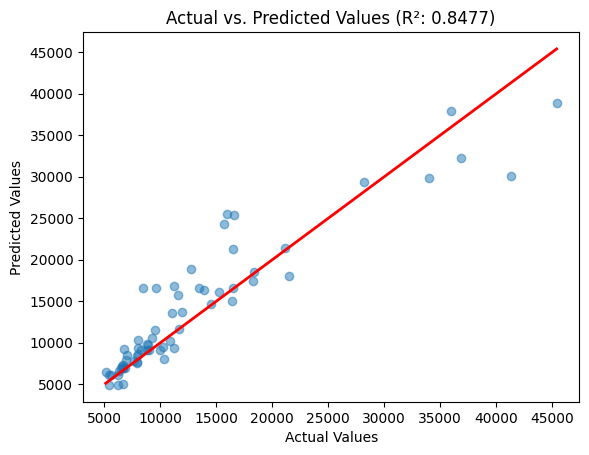

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_predict, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r', lw=2)  # Perfect predictions line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title(f"Actual vs. Predicted Values (R²: {r2:.4f})")
plt.show()


Check the distribution of errors

(array([32., 13.,  5.,  3.,  2.,  3.,  1.,  3.,  1.,  1.]),
 array([2.72242250e+00, 1.13006668e+03, 2.25741095e+03, 3.38475521e+03,
        4.51209947e+03, 5.63944373e+03, 6.76678799e+03, 7.89413225e+03,
        9.02147651e+03, 1.01488208e+04, 1.12761650e+04]),
 <BarContainer object of 10 artists>)

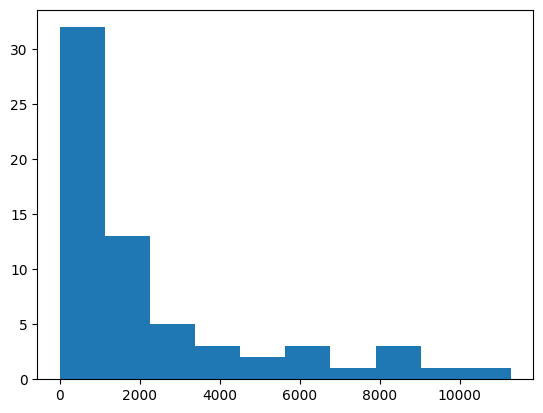

In [ ]:
plt.hist(np.abs(y_test-y_predict))

{'whiskers': [<matplotlib.lines.Line2D at 0x7e074667abd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7e074667bf10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7e074667a450>],
 'medians': [<matplotlib.lines.Line2D at 0x7e074666a990>],
 'fliers': [<matplotlib.lines.Line2D at 0x7e0746685950>],
 'means': []}

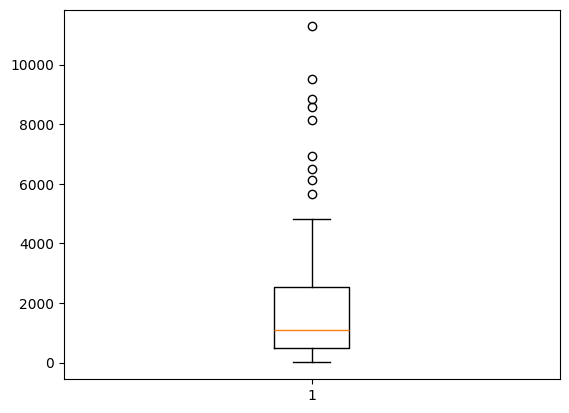

In [ ]:
plt.boxplot(np.abs(y_test-y_predict))

In [ ]:
# The median value is the orange line on the boxplot
np.abs(y_test- y_predict).median()

1097.803510208606

In [ ]:
# This is the value of the 75th percentile
np.percentile(np.abs(y_test- y_predict),80)

3770.207245415263